In [1]:
import re
import copy
import json

import datetime as dt
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

In [2]:
dat=pd.read_csv('datasets/dat.csv')
viscat=list(pd.read_csv('viscat_rename.csv')['0'])

In [21]:
la=dat['label']

In [3]:
from scipy.special import gammaln # x! = Gamma(x+1)\
from scipy.optimize import curve_fit
from scipy.stats import poisson
import copy
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

def tfm_poisson_pdf(x, mu):
    y, J = transformation_and_jacobian(x)
    # For numerical stability, compute exp(log(f(x)))
    return np.exp(y * np.log(mu) - mu - gammaln(y + 1.)) * J

def transformation_and_jacobian(x):
    return 1./x, 1./x**2.

def fit_function(k, lamb):
    from scipy.stats import poisson
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

In [58]:
def mask_test(masktest, b):
    pd=[np.count_nonzero(patv) for patv in masktest[boolr]]
    nonpd=[np.count_nonzero(patv) for patv in masktest[~boolr]]

    if b=='custom':
        bin_range_pd=round(np.mean(pd))+20
        bins_pd=np.arange(bin_range_pd) - 0.5
        
        bin_range_nonpd=round(np.mean(nonpd))+20
        bins_nonpd=np.arange(bin_range_nonpd) - 0.5
    else:
        bins=b
        
    h_pd = histogram(pd,bins=bins_pd,density=True)
    h_nonpd = histogram(nonpd,bins=bins_nonpd,density=True)
    
    center_pd = (h_pd[1][:-1]+h_pd[1][1:])/2
    center_nonpd = (h_nonpd[1][:-1]+h_nonpd[1][1:])/2

    if np.isnan(sum(h_pd[0])) or np.isnan(sum(h_nonpd[0])):
        print('# of bins not working')
#         break
    try:
        p0_pd = 1 / np.mean(pd)
        pois_opt_pd, _ = curve_fit(fit_function, center_pd, h_pd[0], p0=p0_pd)
        
        p0_nonpd = 1/ np.mean(nonpd)
        pois_opt_nonpd, _ = curve_fit(fit_function, center_nonpd, h_nonpd[0], p0=p0_nonpd)
        
        minV=min(pois_opt_pd, pois_opt_nonpd)
        maxV=max(pois_opt_pd, pois_opt_nonpd)
        
#         #ORIGINAL
#         if pois_opt_pd<pois_opt_nonpd:
#             lam=pois_opt_pd
#             bins=bins_pd
#         else:
#             lam=pois_opt_nonpd
#             bins=bins_nonpd
            
#         #TUNED 
        if maxV<1.3: #case1
            pois_opt_pd, pois_opt_nonpd = 3,3
        elif maxV>20:
            pois_opt_pd, pois_opt_nonpd = 3,3
        elif minV<1: #case2
            alpha=0.5
            
            if minV==pois_opt_pd:
                pois_opt_pd=3
                pois_opt_nonpd=minV+alpha
            else:
                pois_opt_pd=minV+alpha
                pois_opt_nonpd=3
        else:#case3
            if minV==pois_opt_pd:
                pois_opt_pd=pois_opt_pd+1
                pois_opt_nonpd=minV
            else:
                pois_opt_pd=minV
                pois_opt_nonpd=pois_opt_nonpd+1
        
        if maxV==pois_opt_pd:
            bins=bins_pd
        else:
            bins=bins_nonpd        
        
    except RuntimeError:
        print('could not fit')
#         break


# #ORIGINAL
#     maskN=np.random.poisson(lam=lam, size=len(la)).astype(int)
#     for j in range(len(la)):
#         masktest.numpy().squeeze()[j][maskN[j]:]=0

#TUNED
    negN=len(la)-sum(boolr)
    maskN_nonpd=np.random.poisson(lam=pois_opt_nonpd, size=negN).astype(int)

    find_nonPDAC=np.where(la==0)[0]
    for j in range(len(find_nonPDAC)):
        masktest[find_nonPDAC[j]]=masktest[find_nonPDAC[j]][:maskN_nonpd[j]]
        
    posN=sum(boolr)
    maskN_pd=np.random.poisson(lam=pois_opt_pd, size=posN).astype(int)

    find_PDAC=np.where(la==1)[0]
    for j in range(len(find_PDAC)):
        masktest[find_PDAC[j]]=masktest[find_PDAC[j]][:maskN_pd[j]]

    return masktest, bins, pois_opt_pd, pois_opt_nonpd

In [59]:
def draw_hist(data, bins, color):
    h= hist(data, bins=bins, density=True, color=color, alpha=0.3)
    bins_edges=h[1]
    entries=h[0]
    center = (bins_edges[:-1]+bins_edges[1:])/2
    
    p0 = 1 / np.mean(data)

    pois_opt, _ = curve_fit(fit_function, center, entries, p0=p0)
    spl1 = make_interp_spline(center, fit_function(center, *pois_opt), k=3)
    
    xnew = np.linspace(bins_edges.min(), bins_edges.max(), 300)  
    power_smooth1 = spl1(xnew)
    plt.plot(xnew, power_smooth1, color=color)
    
    return pois_opt

In [60]:
def draw_histNoline(data, bins, color):
    h= hist(data, bins=bins, density=True, color=color, alpha=0.3)
    bins_edges=h[1]
    entries=h[0]
    center = (bins_edges[:-1]+bins_edges[1:])/2
    
    p0 = 1 / np.mean(data)

    pois_opt, _ = curve_fit(fit_function, center, entries, p0=p0)
    spl1 = make_interp_spline(center, fit_function(center, *pois_opt), k=3)
    
    xnew = np.linspace(bins_edges.min(), bins_edges.max(), 300)  
    power_smooth1 = spl1(xnew)
#     plt.plot(xnew, power_smooth1, color=color)

In [61]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

C:\Users\jp4147\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jp4147\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jp4147\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

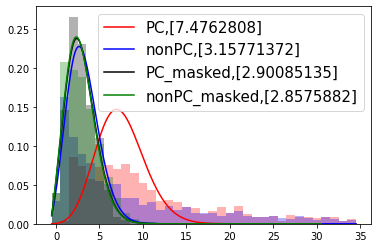

In [69]:
catn=11 #variable number

#eval
data_eval=[eval(i) for i in dat[viscat[catn]]]
#float
data_float=[]
for de in data_eval:
    data_float.append([float(j) for j in de if is_number(j)])

data_PDAC=[np.count_nonzero(patv) for patv in np.array(data_float)[boolr]]
data_nonPDAC=[np.count_nonzero(patv) for patv in np.array(data_float)[~boolr]]

if bin_type=='custom':
    bin_range=round(np.mean(data_PDAC))+20
    bins=np.arange(bin_range) - 0.5
else:
    bins=bin_type

pdac_lam=draw_hist(data_PDAC, bins, 'r')
nonpdac_lam=draw_hist(data_nonPDAC, bins, 'b')

dat2=copy.deepcopy(np.array(data_float))
masked, bins, lam_pd, lam_nonpd = mask_test(dat2, bin_type)
maskpd=[np.count_nonzero(patv) for patv in masked[boolr]]
masknonpd=[np.count_nonzero(patv) for patv in masked[~boolr]]

pdac_masked_lam=draw_hist(maskpd, bins, 'k')
nonpdac_masked_lam=draw_hist(masknonpd, bins, 'g')

label1='PC,'+str(pdac_lam)
label2='nonPC,'+str(nonpdac_lam)
label3='PC_masked,'+str(pdac_masked_lam)
label4='nonPC_masked,'+str(nonpdac_masked_lam)

plt.legend([label1,label2,label3,label4],fontsize=15)

lam_pd_.append(lam_pd)
lam_nonpd_.append(lam_nonpd)

In [70]:
lam_df=pd.DataFrame()
lam_df['lam_pd']=[i if i==3 else i[0] for i in lam_pd_]
lam_df['lam_nonpd']=[i if i==3 else i[0] for i in lam_nonpd_]

lam_df

,lam_pd,lam_nonpd
0,3.126377,4.126377
1,3.123400,4.123400
2,3.116724,4.116724
3,3.114447,4.114447
4,3.108776,4.108776
5,3.117412,4.117412
6,3.114688,4.114688
7,3.114621,4.114621
8,3.119054,4.119054
9,3.064651,4.064651
